In [73]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import librosa
from pathlib import Path
import os, sys

music_path = Path("/Users/dogyy/music/音乐训练集/")
dataset = []
files = os.listdir(music_path)
files.remove('.DS_Store')

times = []
for f in files:
    tempdata, sr = librosa.load(music_path / f, sr=None)
    times.append(int(librosa.core.get_duration(tempdata, sr=sr)))
    
    sr = 22050
    # split on sr
    num_slice = int(tempdata.shape[0] / sr)
    tempdata = tempdata[:num_slice * sr]
    tempslice = np.split(tempdata, num_slice, 0)
    
#     tempslice = []
#     start = 0
#     overlap = 0.5
#     while(True):
#         if start+sr > tempdata.shape[0]:
#             break
#         tempslice.append(tempdata[start: start+sr])
#         start += int(sr * (1 - overlap))
    
    datax = []
    for ts in tempslice:
        mean = np.mean(ts)
        std = np.std(ts)
        datax.append([mean, std])
    print("filename: {}\ndatashape: {}\nsr: {}\nnum_slices: {}\n".format(f, tempdata.shape, sr, num_slice))
    dataset.append(datax)

filename: Edvard.mp3
datashape: (882000,)
sr: 22050
num_slices: 40

filename: 029044.mp3
datashape: (1323000,)
sr: 22050
num_slices: 60

filename: 952402_10SamReprise_Zoom.mp3
datashape: (1565550,)
sr: 22050
num_slices: 71

filename: 033340.mp3
datashape: (1300950,)
sr: 22050
num_slices: 59

filename: Electronic.mp3
datashape: (882000,)
sr: 22050
num_slices: 40

filename: Vogue.mp3
datashape: (882000,)
sr: 22050
num_slices: 40

filename: Windows.mp3
datashape: (882000,)
sr: 22050
num_slices: 40

filename: Driv to success.mp3
datashape: (859950,)
sr: 22050
num_slices: 39

filename: Take Me Higher.mp3
datashape: (882000,)
sr: 22050
num_slices: 40

filename: Silence.mp3
datashape: (882000,)
sr: 22050
num_slices: 40

filename: Small Daffs.mp3
datashape: (948150,)
sr: 22050
num_slices: 43

filename: 038775.mp3
datashape: (1300950,)
sr: 22050
num_slices: 59

filename: Follow your dreams.mp3
datashape: (882000,)
sr: 22050
num_slices: 40

filename: Ketsa_-_06_-_Below_Low.mp3
datashape: (811440

In [74]:
from sklearn.mixture import GaussianMixture

x = np.concatenate(dataset, axis=0)
print(x.shape)

# cluster gene
gene_num = 5

clu = GaussianMixture(n_components=gene_num, covariance_type='diag')
clu.fit(x)

(8437, 2)


GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

Edvard.mp3


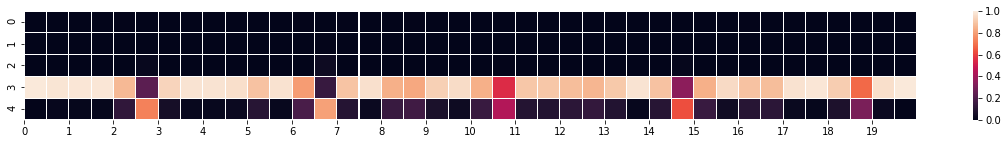

029044.mp3


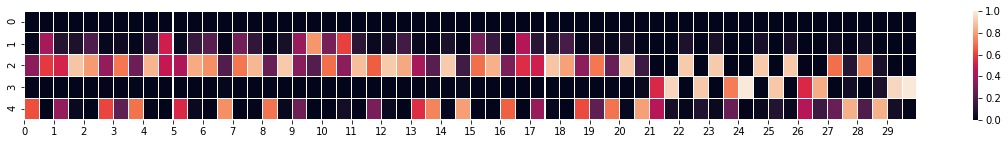

952402_10SamReprise_Zoom.mp3


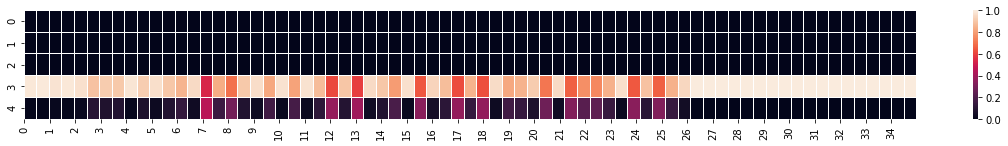

033340.mp3


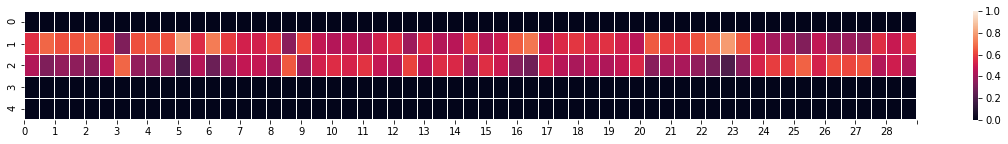

Electronic.mp3


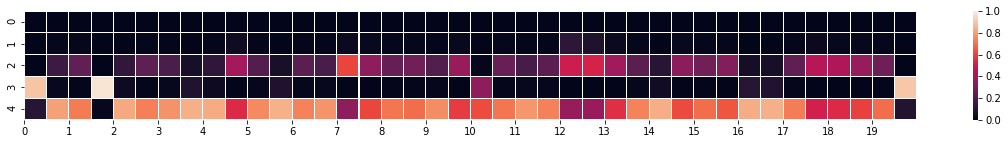

Vogue.mp3


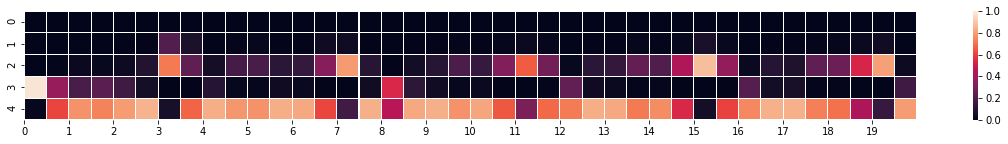

Windows.mp3


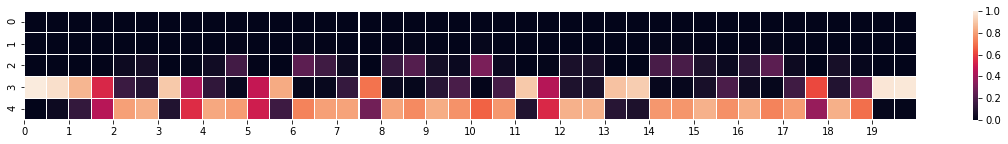

Driv to success.mp3


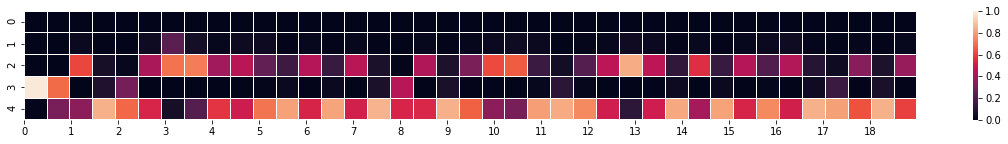

Take Me Higher.mp3


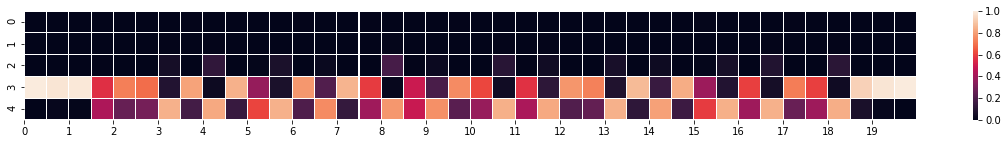

Silence.mp3


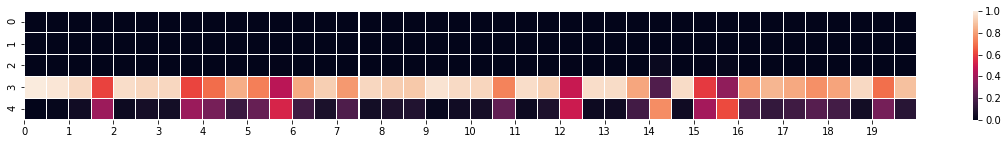

Small Daffs.mp3


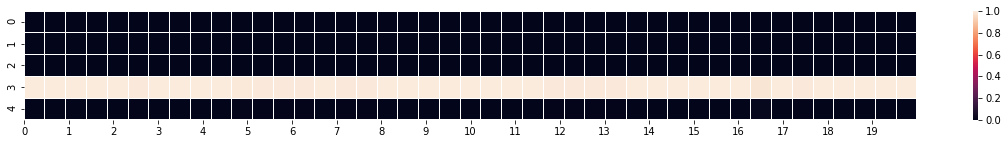

038775.mp3


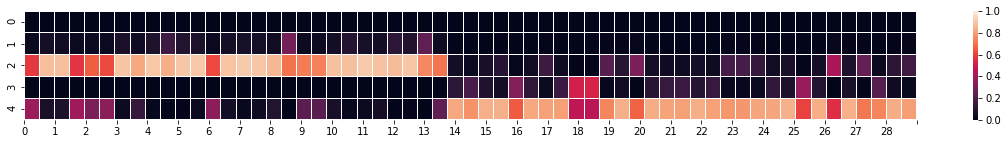

Follow your dreams.mp3


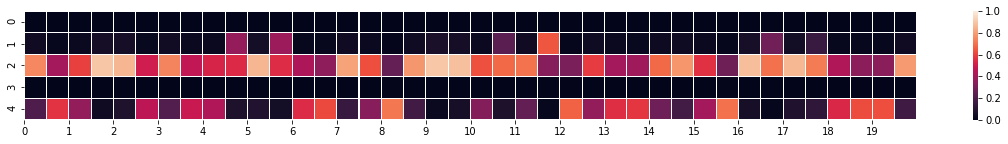

Ketsa_-_06_-_Below_Low.mp3


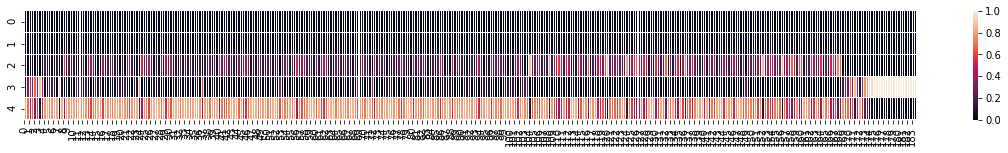

031034.mp3


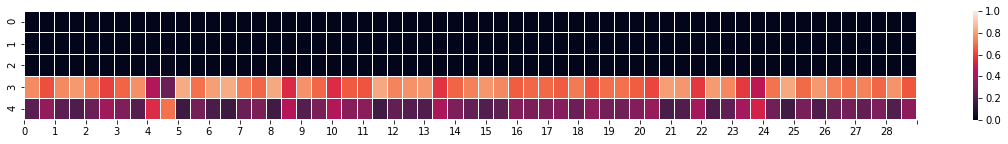

Angel Fire.mp3


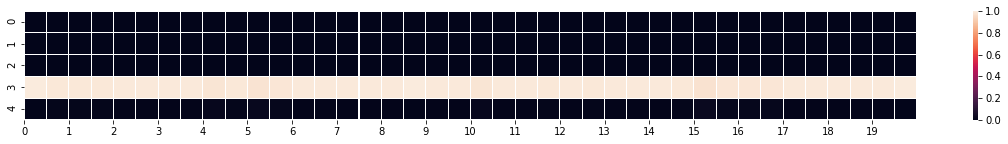

Apple Rag.mp3


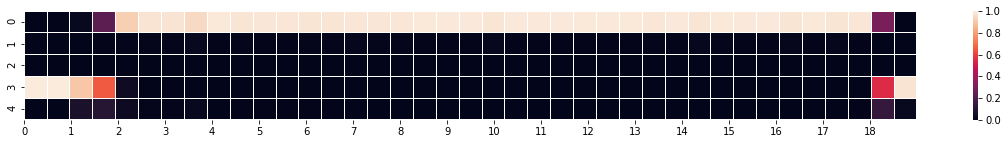

VCG43628488373.mp3


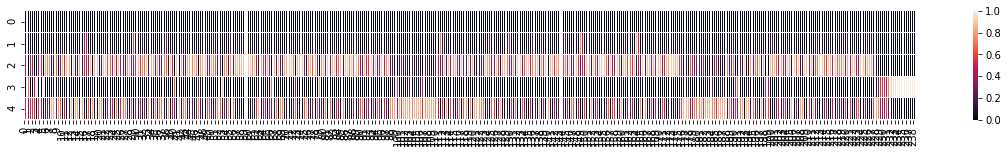

009888.mp3


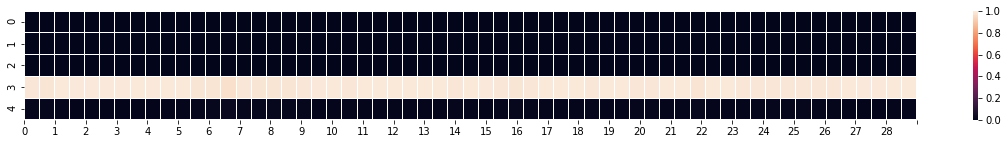

078297.mp3


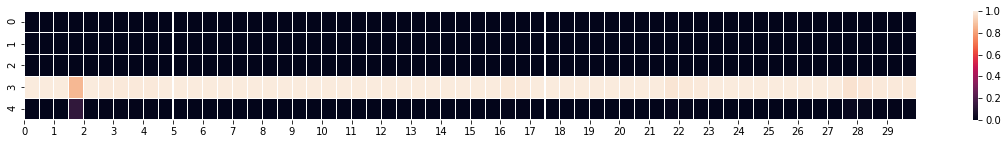

Technology.mp3


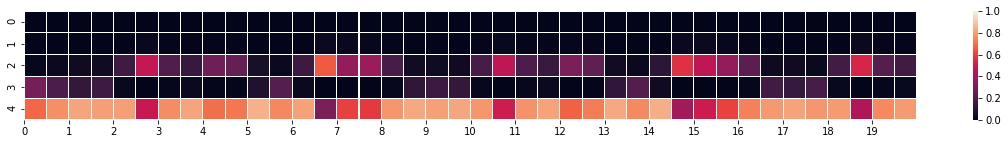

1134737_NazdaqBrixxFtAnna-YouProdR.mp3


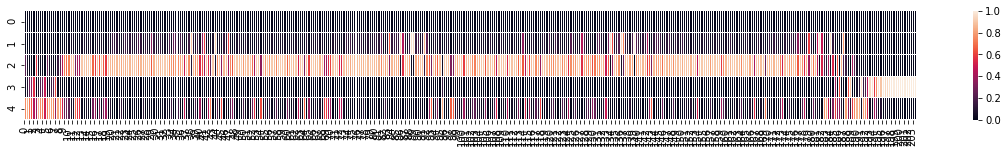

078083.mp3


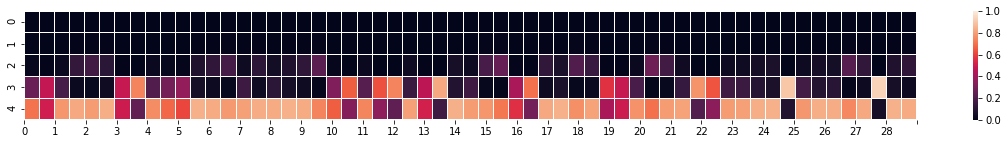

VCG43739695855.mp3


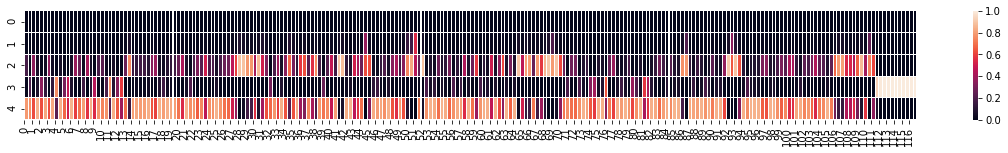

Sunshine Beach.mp3


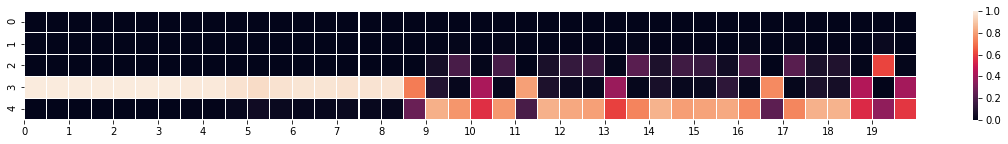

031040.mp3


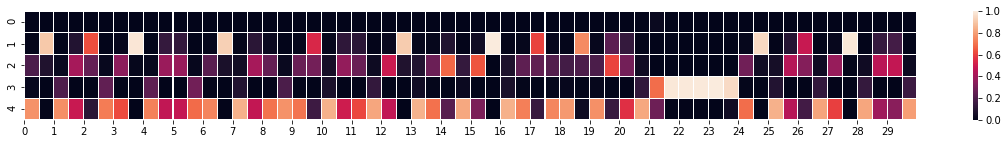

049845.mp3


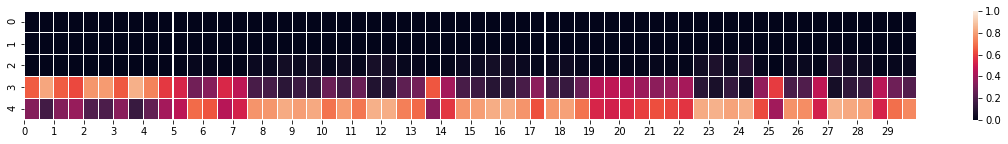

VCG43712916677.mp3


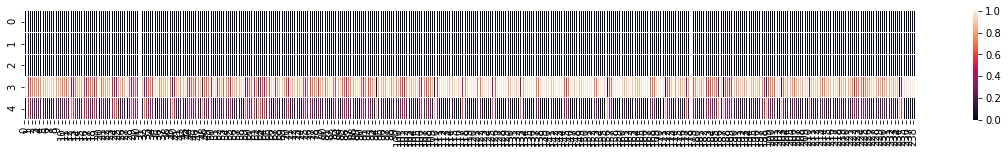

049847.mp3


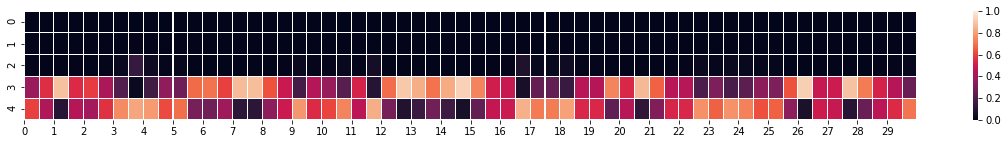

1117653_ForJapanWithLove.mp3


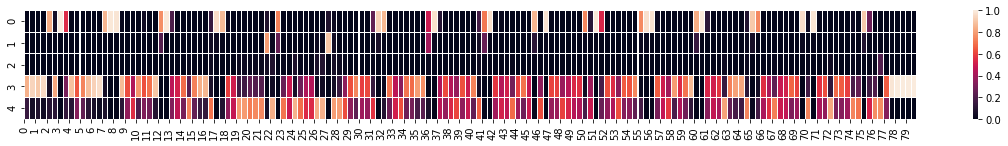

 Sporty.mp3


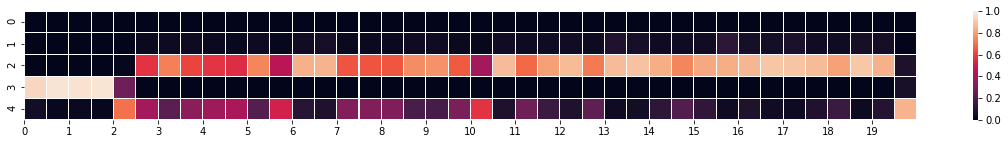

953076_jrock.mp3


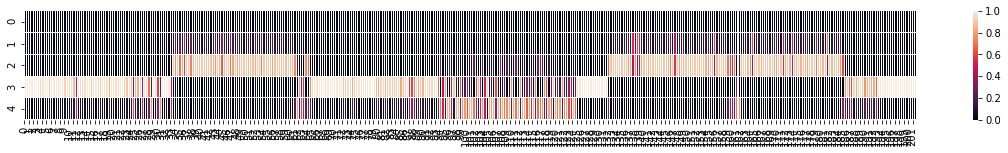

027609.mp3


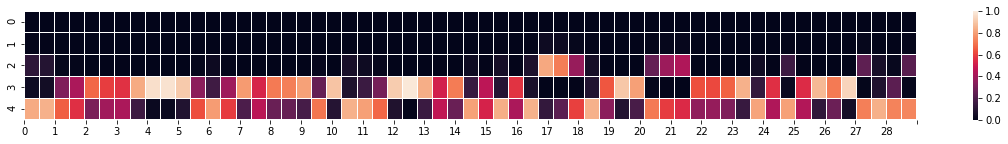

009512.mp3


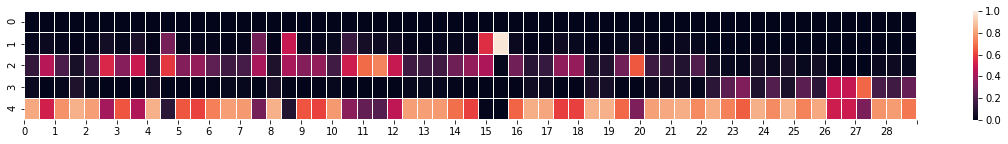

The 49th Street.mp3


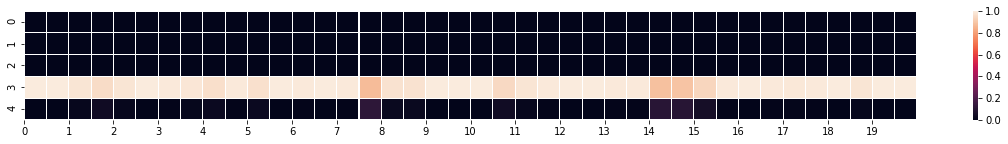

Prelude.mp3


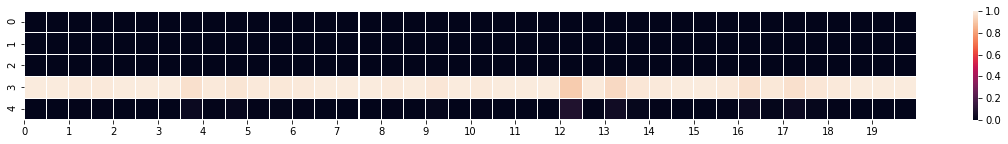

Visualizations.mp3


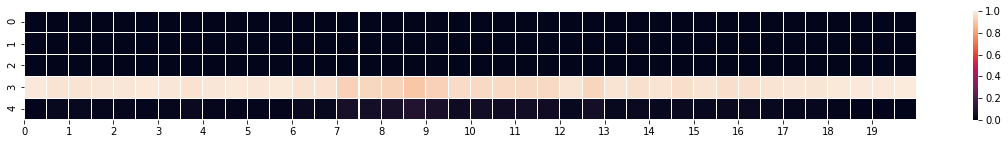

Destination.mp3


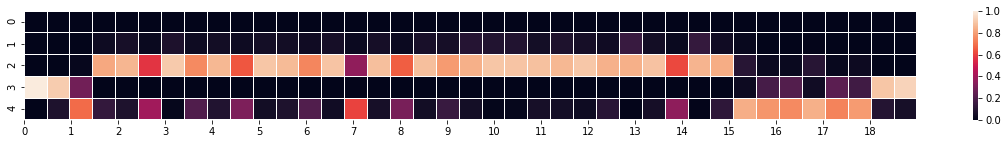

037416.mp3


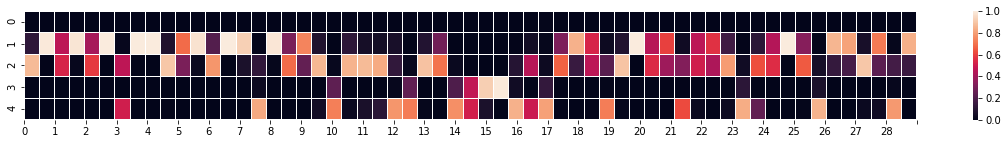

Slow pogo.mp3


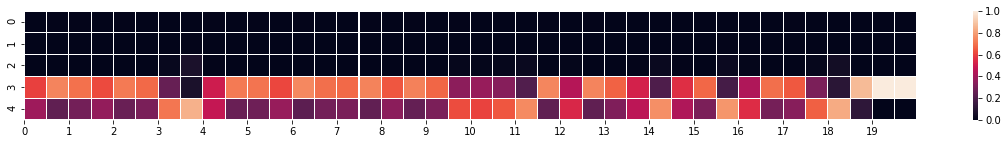

VCG43712942565.mp3


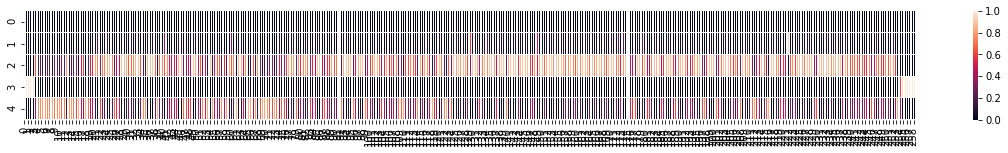

151785.mp3


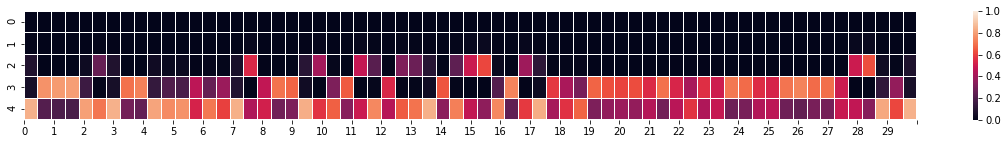

048808.mp3


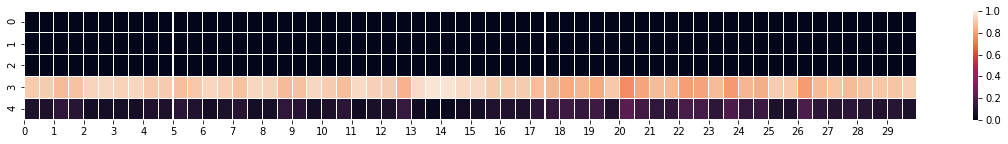

107267.mp3


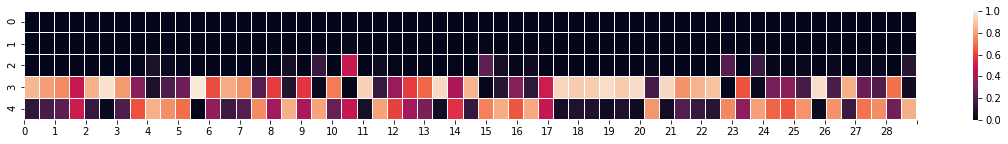

027612.mp3


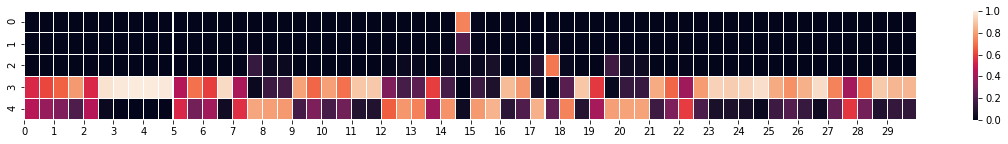

Temperature.mp3


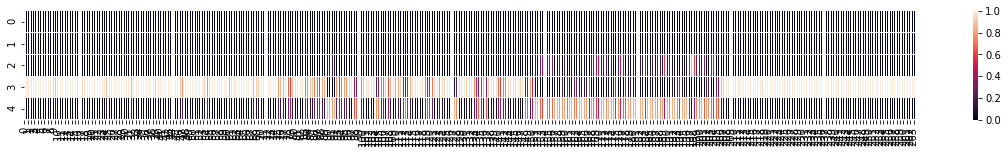

While You Sleep.mp3


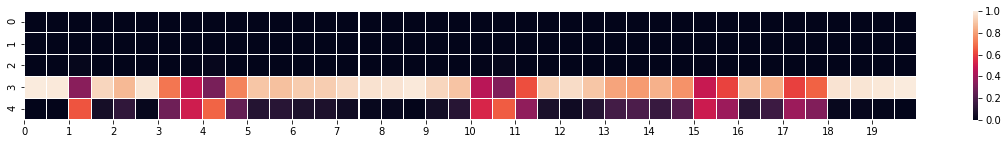

Get Up.mp3


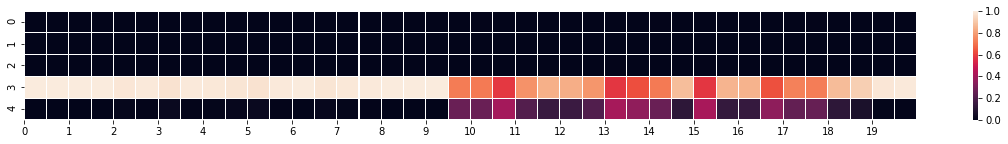

Illusion.mp3


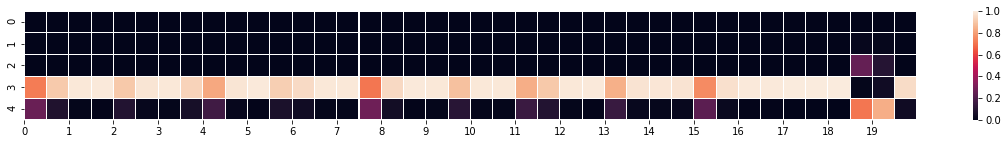

Downfall.mp3


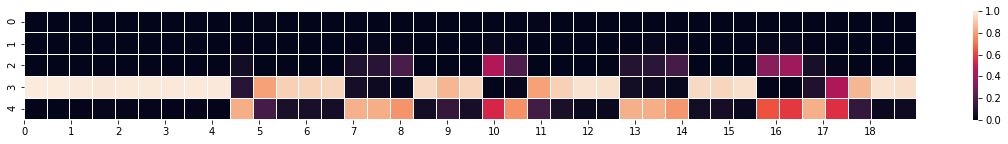

VCG43712372099.mp3


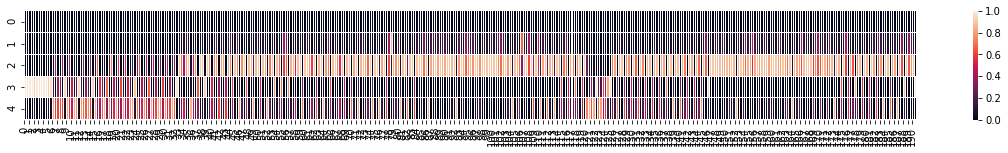

098797.mp3


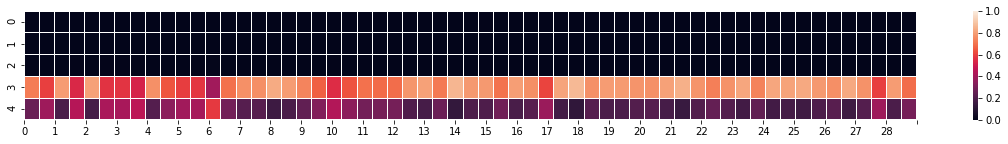

Classical.mp3


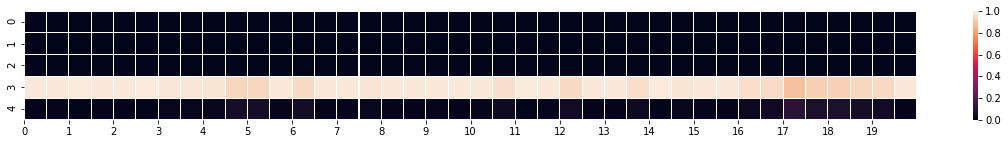

038784.mp3


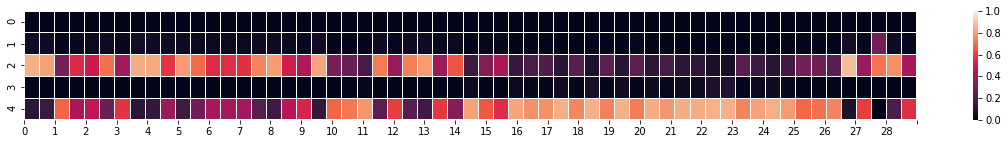

Kiss the Sky.mp3


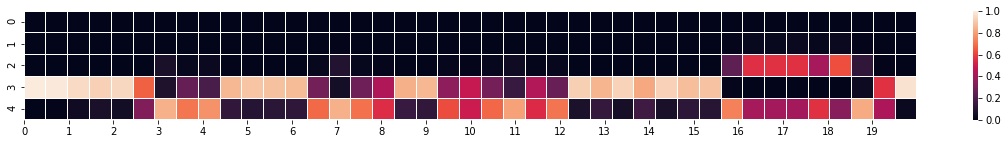

042377.mp3


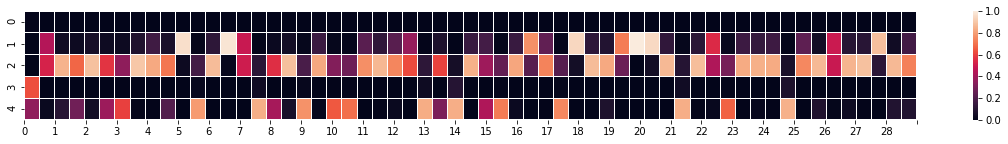

Moonlight.mp3


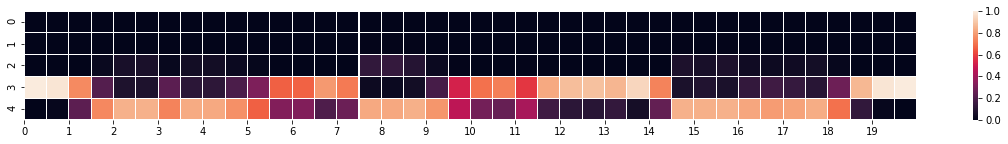

Elegance.mp3


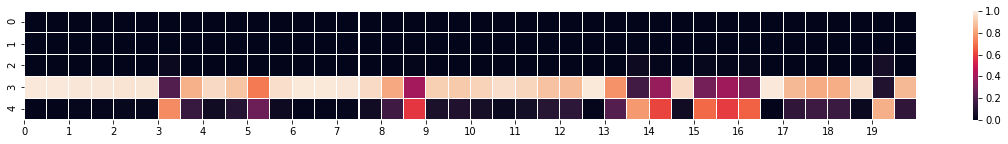

The Walk.mp3


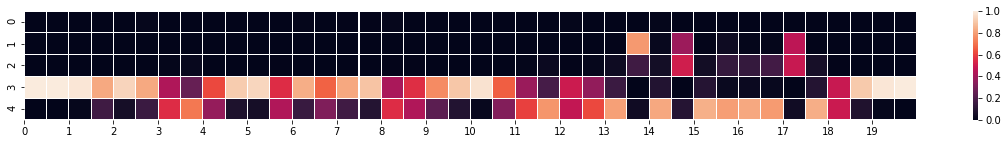

Happy.mp3


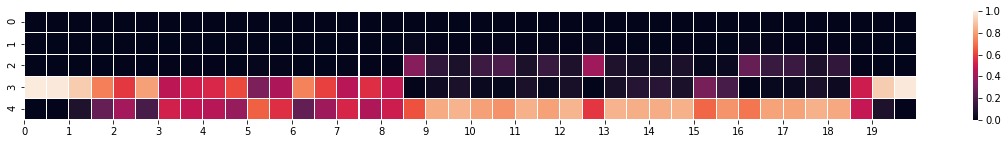

1122693_OneDream.mp3


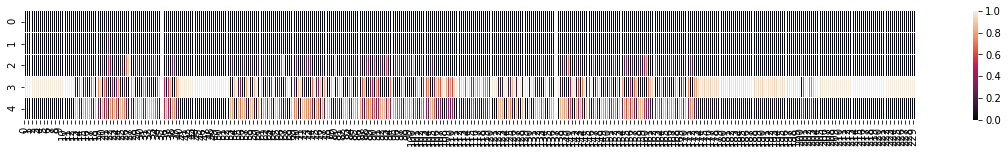

042375.mp3


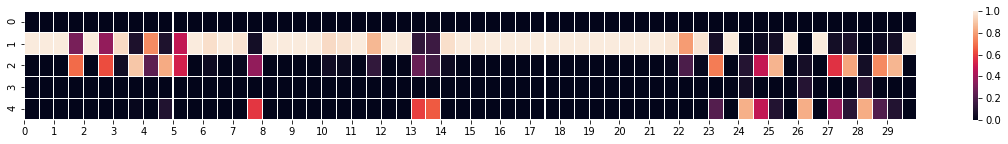

023371.mp3


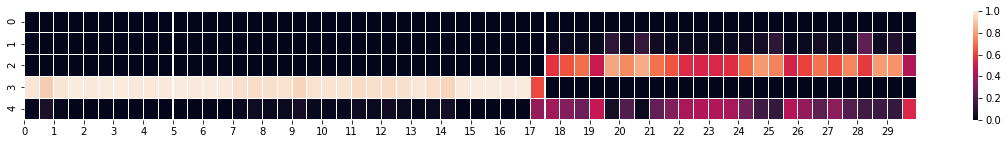

053457.mp3


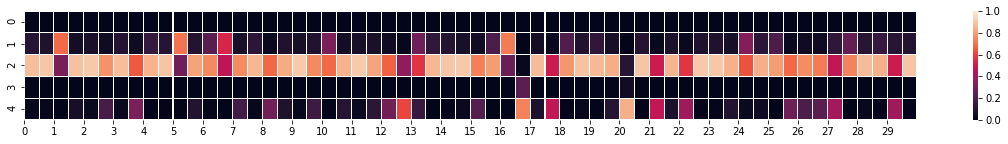

Veloma.mp3


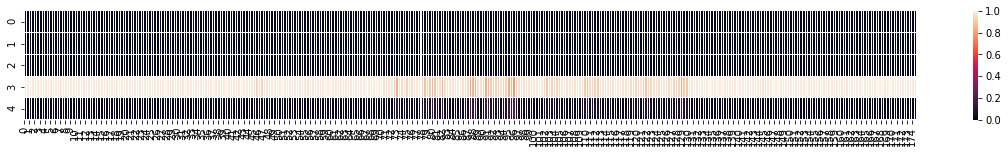

Scott_Holmes_-_03_-_Follow_Your_Dreams.mp3


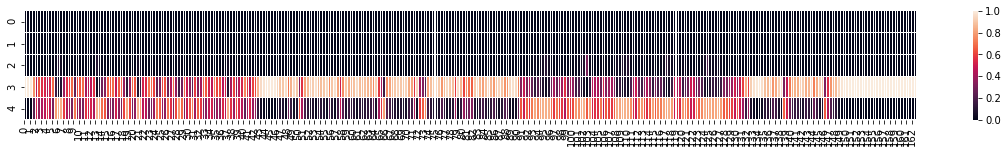

039488.mp3


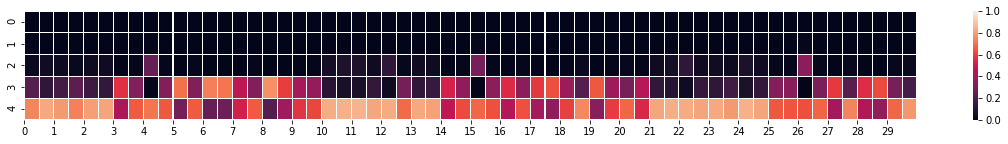

116456.mp3


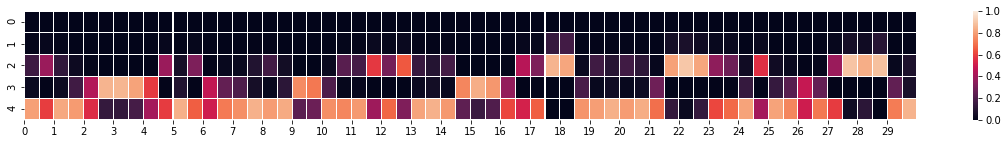

Lights in the Darkness.mp3


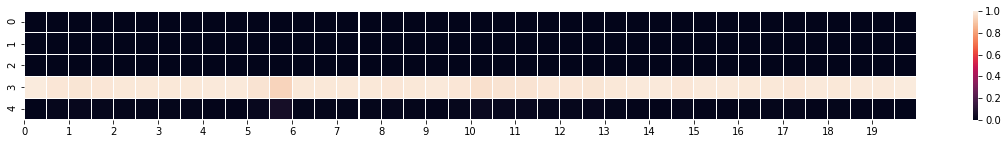

028553.mp3


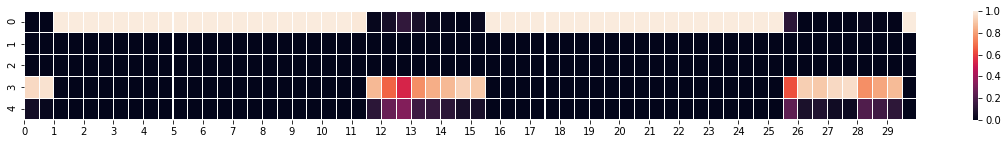

069519.mp3


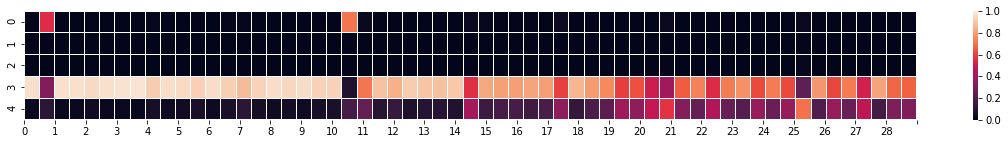

Arround the Lake.mp3


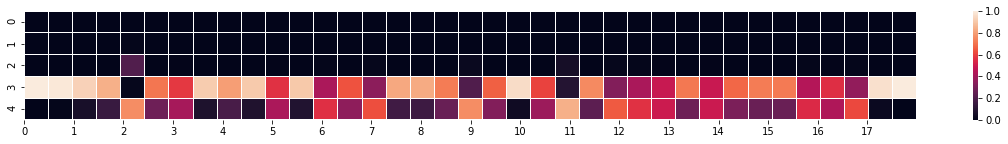

Tour.mp3


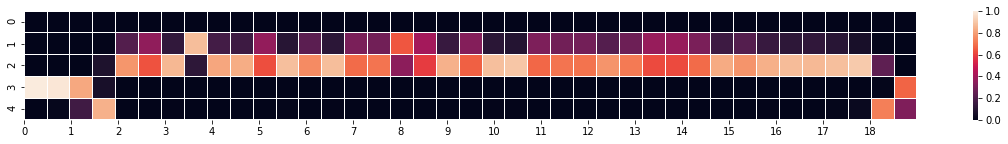

023014.mp3


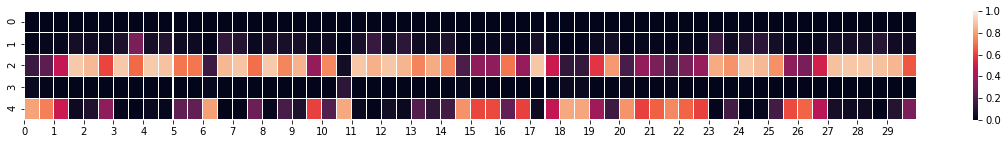

011059.mp3


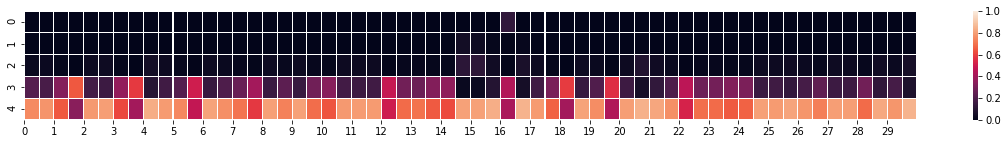

Whistle.mp3


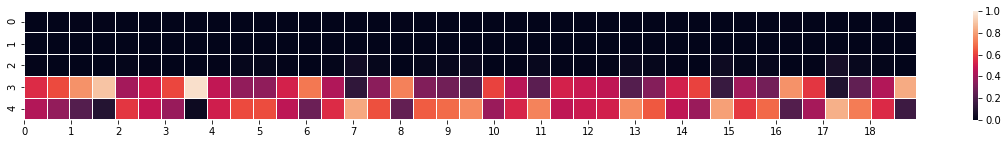

023015.mp3


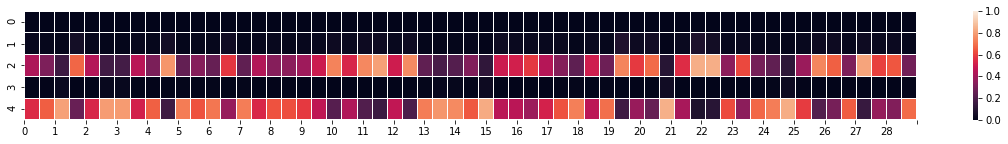

Kid in Fourth.mp3


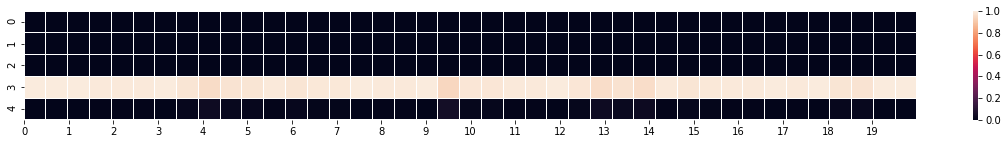

Big adventure.mp3


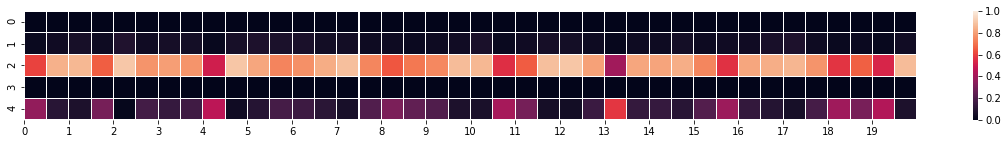

Youth.mp3


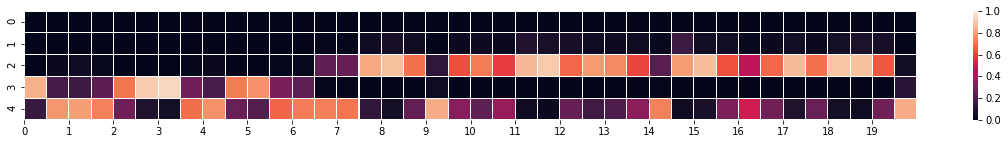

Butterflies.mp3


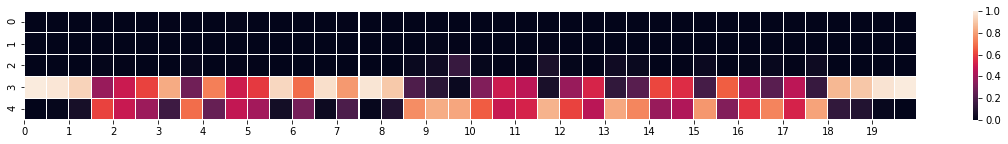

In [75]:
# get gene assign
for filename, data, t in zip(files, dataset, times):
    geneassign = clu.predict_proba(data)
    geneassign = np.transpose(geneassign)
    plt.figure(figsize=(20, 2))
    seaborn.heatmap(geneassign, vmin=0, vmax=1, linewidths=0.01)
    datalength = len(data)
    plt.xticks(np.arange(0, datalength, datalength/(t)), np.arange(t))
    print(filename)
    plt.show()